In [19]:
import pymolpro as pmp
import numpy as np
import math
import os

In [20]:

maindb=pmp.database.Database()

for xyz in os.listdir('pubchem'): 
    if xyz.endswith('.xyz'):
        f=open(f'/home/stuart/Hydrocarbons/pubchem/{xyz}')
        maindb.add_molecule(name=xyz[:-4], geometry=f.read())

db=pmp.database.run(maindb,method='locali,pipek;ccsd',basis='cc-pVTZ', parallel=1, postamble='put,xml')

In [224]:
def dictbuilder(orbital,v):
    oid,noid=orbital.ID,f'-{orbital.ID}'
    #build the grid using n points and evaluate
    points=orbital.grid(n)
    values=orbital.evaluate(points,values=True)
    moments=orbital.second_moment_eigenvalues
    
    moments=np.append(moments,float(v.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]))
    moments=np.append(moments,float(orbital.kinetic_energy))
    orbiaddfeats.update({oid:moments})
    orbiaddfeats.update({f'-{oid}':moments})
    #values=values**2
    #puts them into the dictionaries
    orbitaldt.update({oid:values})
    orbitaldt.update({f'-{oid}':values})
    #probably unnecessary, but works
    if orbital.ID not in griddt:
        griddt[orbital.ID] = {}
        griddt[f'-{orbital.ID}']={}
    #xyz is arbitrary, just to keep consistency and easy to call later
    griddt[oid].update({i:{
        'x':float(points[i][0]),
        'y':float(points[i][1]),
        'z':float(points[i][2])
        }for i in range(len(points))})
    griddt[f'-{oid}'].update({i:{
        'x':float(points[i][0]),
        'y':float(points[i][1]),
        'z':float(points[i][2])
        }for i in range(len(points))})

def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False


def distances(o1,o2):
    big_arr=np.empty((0,n**3))
    for i in range(len(griddt[o1])):
        tmp_list=[]
        for j in range(len(griddt[o2])):
            #find the distance
            o1x,o1y,o1z = griddt[o1][i]['x'], griddt[o1][i]['y'],griddt[o1][i]['z']
            o2x,o2y,o2z = griddt[o2][j]['x'], griddt[o2][j]['y'],griddt[o2][j]['z']
            r=math.sqrt((o1x-o2x)**2+(o1y-o2y)**2+(o1z-o2z)**2)
            #correlation energy should scale like r^-6 so take the reciprocal, going to lead to problems at 0 so take an error function
            if r==0:
                w=1
            else:   
                w=(math.erf(a*r)/r)
            tmp_list.append(float(w))
        tmp_arr=np.array(tmp_list)
        #tmp_arr.reshape((1,len(tmp_list)))
        big_arr=np.vstack((big_arr,tmp_arr))
    
    big_arr=np.vstack((big_arr, orbitaldt[o1], orbitaldt[o2]))
    return big_arr

def centdist(o1,o2):
    o1x,o1y,o1z = centdt[o1][0], centdt[o1][1],centdt[o1][2]
    o2x,o2y,o2z = centdt[o2][0], centdt[o2][1],centdt[o2][2]
    r=math.sqrt((o1x-o2x)**2+(o1y-o2y)**2+(o1z-o2z)**2)
    if r==0:
        return 0
    else:
        return r

In [216]:
d=distances('1.1','2.1')
#print(d)
print(d.shape)
print(centdt)

(66, 64)
{'1.1': array([ 1.19030450e-03, -9.14549390e-03, -1.31795311e-09]), '-1.1': array([ 1.19030450e-03, -9.14549390e-03, -1.31795311e-09]), '2.1': array([ 5.00257173e-02, -8.13195133e-01, -1.22093189e-09]), '-2.1': array([ 5.00257173e-02, -8.13195133e-01, -1.22093189e-09]), '3.1': array([-5.10271166e-02,  8.22340629e-01,  5.90652640e-10]), '-3.1': array([-5.10271166e-02,  8.22340629e-01,  5.90652640e-10]), '4.1': array([ 1.47910646, -1.86383861, -1.17906214]), '-4.1': array([ 1.47910646, -1.86383861, -1.17906214]), '5.1': array([ 1.47909809, -1.86373409,  1.17906828]), '-5.1': array([ 1.47909809, -1.86373409,  1.17906828]), '6.1': array([-4.27095004e-01, -1.08067772e+00, -8.60578003e-06]), '-6.1': array([-4.27095004e-01, -1.08067772e+00, -8.60578003e-06]), '7.1': array([-2.35372446, -0.34896962, -1.17908717]), '-7.1': array([-2.35372446, -0.34896962, -1.17908717]), '8.1': array([-2.35373727, -0.3490727 ,  1.17897854]), '-8.1': array([-2.35373727, -0.3490727 ,  1.17897854]), '9.1':

In [225]:
#settings
#number of grid points to use (will increase input features n**3 and compute time the same way so dont go too high
n=4

#alpha in the error function

a=1

#the arrays are stored in a list until the end of the calculations to then be np.stack()
selffeaturelist=[]
selfaddfeatslist=[]
selflabellist=[]
noselffeatlist=[]
noselfaddfeatlist=[]
noselflabellist=[]

distancelist=[]

for k,v in db.projects.items():
    #used to store the density key = orbital ID, values=orbital.evaluate
    orbitaldt={}
    #stores the XYZ coordinates for the grid to later be used for the distances. key= orbital id, values= 'x','y','z'
    griddt={}
    #additional features, second moments, orbital energy.
    orbiaddfeats={}
    #centroid dictionary
    centdt={}
    for orbital in v.orbitals():
        #stores the evaluated orbital and grid coordinates in different dictionaries
        dictbuilder(orbital,v)
        centdt.update({orbital.ID:orbital.centroid})
        centdt.update({f'-{orbital.ID}':orbital.centroid})
    
    for pair in v.xpath("//pair"):
        temp=pmp.element_to_dict(pair)
        oid1,oid2=temp['orbital1'],temp['orbital2']
        if chkorbid(oid1,oid2)==True:
            selffeaturelist.append(np.array(orbitaldt[oid1]))
            selfaddfeatslist.append(np.array(orbiaddfeats[oid1]))
            selflabellist.append(float(temp['energy']))
        else:
            noselffeatlist.append(distances(oid1,oid2))
            noselfaddfeatlist.append(np.append(orbiaddfeats[oid1],orbiaddfeats[oid2]))
            noselflabellist.append(float(temp['energy']))
            distancelist.append(centdist(oid1,oid2))
            
            
                                     

selffeatures=np.stack(selffeaturelist)
selfaddfeatures=np.stack(selfaddfeatslist)
selflabels=np.stack(selflabellist) 
noselffeatures=np.stack(noselffeatlist)
noselfaddfeatures=np.stack(noselfaddfeatlist)
noselflabellist=np.stack(noselflabellist)

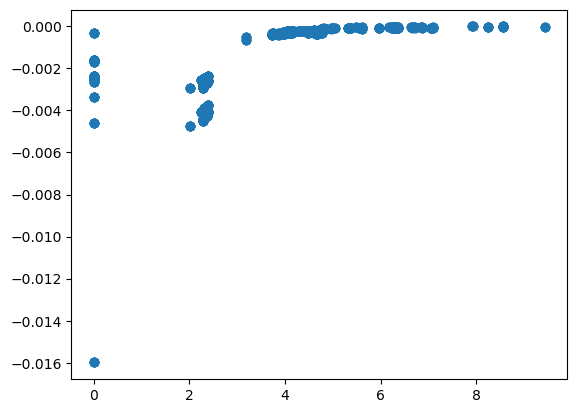

In [226]:
plt.scatter(distancelist,noselflabellist)
plt.show()

In [5]:
import tensorflow as tf
import keras

selfdataset=tf.data.Dataset.from_tensor_slices((selffeatures,selflabels))
selfdataset=selfdataset.shuffle(buffer_size=len(selflabellist)).batch(batch_size=1)

inp_shape=(n**3+9,)

model=keras.Sequential([
    keras.layers.Input(shape=inp_shape),
    keras.layers.Dense(256, activation='softmax'),
    keras.layers.Dense(1)
])
model.compile('Adam',loss='huber')
model.fit(selfdataset,epochs=50)
predictions=[i for i in model.predict(selfdataset)]



2024-08-17 21:54:50.348481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 21:54:50.928083: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 21:54:51.066199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 21:54:52.062286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 21:54:57.524494: W tensorflow/compiler/tf2

Epoch 1/50


I0000 00:00:1723928106.372379    5379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723928106.376441    5379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723928106.379553    5379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723928106.598346    5379 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 2.5561e-05  
Epoch 2/50
  1/166 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1275e-06

I0000 00:00:1723928110.625355    5479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 5.3235e-07
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 7.3480e-07
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 4.5542e-07
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 4.2730e-07
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - loss: 5.9940e-07
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 6.1769e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 6.3277e-07
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 6.4064e-07
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 7.1522e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 7.0890e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 7.1035e-07
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 5.5415e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 6.7716e-07
Epoch 15/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - 

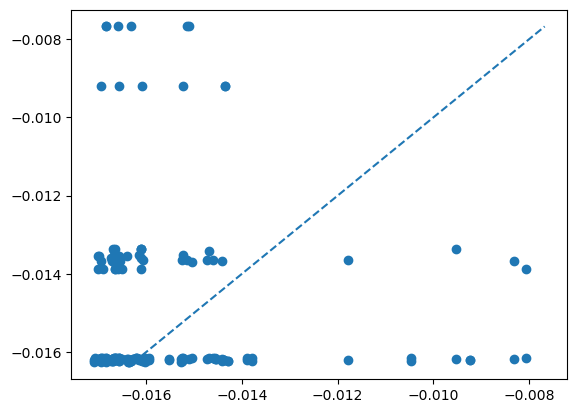

In [8]:
import matplotlib.pyplot as plt

plt.scatter(predictions,selflabellist)
plt.plot((min(selflabellist),max(selflabellist)),(min(selflabellist),max(selflabellist)), linestyle='--')

In [14]:
from sklearn.metrics import mean_squared_error
import gc
def buildmodel(acti,depth):
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=inp_shape))
    model.add(keras.layers.Dense(200,activation='softmax'))
    for i in range(depth):
        model.add(keras.layers.Dense(200,activation=acti))
    model.add(keras.layers.Dense(1))
    model.compile('Adam',loss='Huber')
    return model

acti_list=['sigmoid','relu','tanh']
units_list=[i for i in range(64,320,64)]

sig_resultslist=[]
mish_resultslist=[]
relu_resultslist=[]
tanh_resultslist=[]
for depth in range(1,10):
    for acti in acti_list:
        keras.backend.clear_session()
        gc.collect()
        print(model.summary())
        model=buildmodel(acti,depth)
        model.fit(selfdataset,epochs=50)
        predictions=model.predict(selfdataset)
        if acti=='sigmoid':
            sig_resultslist.append(mean_squared_error(selflabellist,predictions))
        elif acti=='relu':
            relu_resultslist.append(mean_squared_error(selflabellist,predictions))
        elif acti=='tanh':
            tanh_resultslist.append(mean_squared_error(selflabellist,predictions))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,401 (208.60 KB)

 Trainable params: 53,401 (208.60 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - loss: 0.0012
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 5.8116e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 3.3641e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 3.2142e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 3.4535e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 8.2472e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 3.3398e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 4.0051e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - loss: 4.5309e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 7.4370e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 1.3058e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 7.4977e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 8.9440e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 60

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,605 (646.90 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,404 (431.27 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 1.0387e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 1.6219e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 2.0358e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 2.1659e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 1.2965e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 8.4179e-07
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 1.4288e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss: 5.1136e-07
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 7.5435e-07
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 7.9284e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 8.8102e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 1.2956e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 6.8581e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,605 (646.90 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,404 (431.27 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - loss: 2.3222e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 1.8638e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 1.0357e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 3.3098e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 1.1932e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - loss: 1.0492e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 8.3021e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 6.5063e-07
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 8.4504e-07
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 3.4926e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 9.1008e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 1.9412e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 6.1703e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,605 (646.90 KB)

 Trainable params: 55,201 (215.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,404 (431.27 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - loss: 0.0092
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 1.1556e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 1.3611e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.1756e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 3.0825e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 3.1711e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 3.0830e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 2.1175e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 2.5643e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 3.2153e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 2.8368e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 5.4592e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 7.0633e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 67

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,205 (1.09 MB)

 Trainable params: 95,401 (372.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 190,804 (745.33 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - loss: 1.2179e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.1915e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 9.7478e-07
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 8.1568e-07
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 9.1857e-07
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 1.4242e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 9.9762e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 7.0946e-07
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 1.7291e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 7.5424e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 7.2009e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 7.9101e-07
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 9.2626e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,205 (1.09 MB)

 Trainable params: 95,401 (372.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 190,804 (745.33 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - loss: 6.4043e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 3.2291e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 3.6485e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 1.5712e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 2.5976e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 3.6180e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 1.4887e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 1.7512e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1.9622e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.4795e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 2.3534e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 2.4642e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 1.2965e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,205 (1.09 MB)

 Trainable params: 95,401 (372.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 190,804 (745.33 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - loss: 0.0057
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1.8384e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 1.1757e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 8.1767e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 2.8054e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 6.7691e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 4.6613e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 2.1299e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 3.1480e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 6.3136e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 7.5881e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - loss: 4.8439e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 2.0085e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 96

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,805 (1.55 MB)

 Trainable params: 135,601 (529.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 271,204 (1.03 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.9569e-06  
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - loss: 3.5519e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1.6714e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.7475e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1.4377e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 7.9482e-07
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 9.3197e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 1.2086e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 1.9727e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 8.6502e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 7.5996e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 9.0460e-07
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 5.8170e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,805 (1.55 MB)

 Trainable params: 135,601 (529.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 271,204 (1.03 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - loss: 9.7494e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 1.2709e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 1.5011e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - loss: 1.0856e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1.4191e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 8.3854e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 2.6573e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 1.7212e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 1.1853e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 8.6996e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 1.0401e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 2.9509e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - loss: 8.4965e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,805 (1.55 MB)

 Trainable params: 135,601 (529.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 271,204 (1.03 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0077
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 1.5345e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 2.3624e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 1.7249e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 3.2404e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 2.7979e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 4.2142e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 3.0186e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 7.4216e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 7.3214e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 5.6790e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 8.8243e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 3.6877e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 730u

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,405 (2.01 MB)

 Trainable params: 175,801 (686.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 351,604 (1.34 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.2798e-06
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 3.3394e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 2.5093e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 1.9251e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.0653e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 1.0160e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 1.6316e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.2658e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 8.2189e-07
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 1.0566e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 9.4390e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 8.5387e-07
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 5.9496e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,405 (2.01 MB)

 Trainable params: 175,801 (686.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 351,604 (1.34 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.1447e-04  
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 9.2339e-07
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 9.2156e-07
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 2.4115e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 2.0041e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 1.8522e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 1.8770e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.7198e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 2.1099e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 4.2420e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 2.5660e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 1.8445e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 2.5963e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,405 (2.01 MB)

 Trainable params: 175,801 (686.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 351,604 (1.34 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0079
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 7.8220e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 2.4949e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 2.1091e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 3.4373e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 8.4457e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 2.9282e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 5.6807e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 7.6377e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 9.7407e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 6.0195e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 1.4588e-04
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 6.3297e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 887u

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,005 (2.47 MB)

 Trainable params: 216,001 (843.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 432,004 (1.65 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 9.9873e-06
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 6.7135e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 4.9183e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 2.4710e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 1.9277e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 1.8003e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 1.1776e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 1.4667e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.1681e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 8.4733e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 7.1244e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 7.4902e-07
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 7.2876e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,005 (2.47 MB)

 Trainable params: 216,001 (843.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 432,004 (1.65 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.5263e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 1.0559e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.4146e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.9623e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 1.1326e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 2.2533e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 8.0230e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 1.3570e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 2.9609e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 1.6676e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 1.5215e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 1.4130e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 1.2509e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,005 (2.47 MB)

 Trainable params: 216,001 (843.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 432,004 (1.65 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0218
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1.1710e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 6.8386e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 1.1826e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1366e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 3.8962e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 1.9069e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 2.5618e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7325e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7881e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 5.3779e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7420e-05  
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 5.0034e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 768,605 (2.93 MB)

 Trainable params: 256,201 (1000.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 512,404 (1.95 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1450e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 5.7497e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 3.7387e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2884e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 3.9250e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - loss: 2.3732e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 2.9883e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6360e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 3.3411e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 4.9803e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 2.6362e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6712e-06  
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 5.2910e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 919u

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 768,605 (2.93 MB)

 Trainable params: 256,201 (1000.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 512,404 (1.95 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.9026e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 1.0668e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1174e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0410e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 2.0433e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 3.4324e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 3.2703e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 1.6907e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 1.9472e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7886e-07 
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3147e-06  
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 3.6016e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 1.3881e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 848us

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 768,605 (2.93 MB)

 Trainable params: 256,201 (1000.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 512,404 (1.95 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0099
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0494e-05 
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 1.7270e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 3.7853e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 3.9370e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 4.4865e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2365e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - loss: 8.1038e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 3.5527e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 7.9954e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 5.6939e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - loss: 8.8562e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 4.1382e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889,205 (3.39 MB)

 Trainable params: 296,401 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 592,804 (2.26 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2887e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 5.1498e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 3.1935e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 3.8050e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 4.1830e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 4.0607e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5485e-06 
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 5.8797e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 3.0879e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 3.1387e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 3.0620e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 4.5345e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 2.4671e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889,205 (3.39 MB)

 Trainable params: 296,401 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 592,804 (2.26 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.7400e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1514e-06 
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 1.5828e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 1.5588e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 2.4414e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 4.2593e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1.6582e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 2.0869e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1.9372e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1.2086e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 1.9906e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 2.6929e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1.1714e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889,205 (3.39 MB)

 Trainable params: 296,401 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 592,804 (2.26 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0845
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7271e-06 
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 7.7070e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 1.0915e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1629e-06 
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9989e-06 
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1674e-05 
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0027e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 1.1855e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 2.6139e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1355e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9004e-05 
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.6537e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,009,805 (3.85 MB)

 Trainable params: 336,601 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 673,204 (2.57 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3689e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3941e-06 
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1525e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8137e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3385e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8282e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4857e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 3.3180e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3517e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6592e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0725e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1223e-06 
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9079e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 2

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,009,805 (3.85 MB)

 Trainable params: 336,601 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 673,204 (2.57 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.4001e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5153e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8252e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5659e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8475e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 2.2124e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5290e-06 
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 2.2890e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9417e-06 
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 8.5545e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 7.0275e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3978e-06 
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.0088   
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step -

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,009,805 (3.85 MB)

 Trainable params: 336,601 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 673,204 (2.57 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0164
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 1.1911e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 2.4307e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2942e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6540e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3969e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6315e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7842e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2844e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5528e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2925e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4477e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9736e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5926e

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,405 (4.31 MB)

 Trainable params: 376,801 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 753,604 (2.87 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.1778e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5682e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1054e-06 
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0072e-06 
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4831e-06 
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6134e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 2.7149e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 3.0682e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3094e-06  
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5637e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4761e-06 
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4533e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5601e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        14,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,130,405 (4.31 MB)

 Trainable params: 376,801 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 753,604 (2.87 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.8872e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3900e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 3.4620e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 3.0388e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 7.0245e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2094e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8714e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5326e-06 
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6471e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8550e-06 
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3909e-06  
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6224e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0107e-06 
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - 

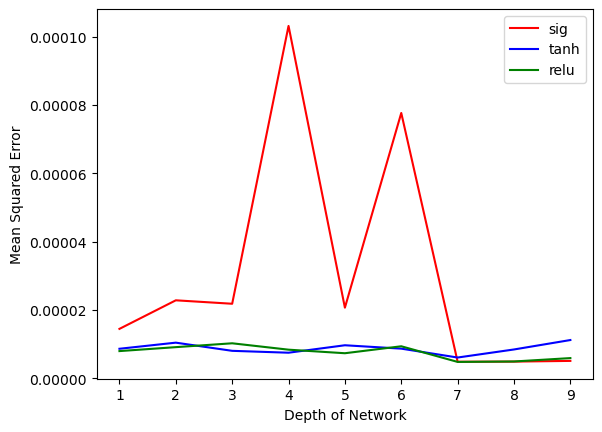

In [15]:
depth_list=[i for i in range(1,10)]
plt.plot(depth_list,sig_resultslist, c='red',label='sig')
plt.plot(depth_list,tanh_resultslist,c='blue',label='tanh')
plt.plot(depth_list,relu_resultslist, c='green',label='relu')

plt.xlabel('Depth of Network')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('d2depthvmse.png')
plt.show()

In [6]:
model1=keras.Sequential([
    keras.layers.Input(shape=inp_shape),
    keras.layers.Dense(200,activation='softmax')
    ])
model2=model1
model3=model1
for i in range(7):
    model1.add(keras.layers.Dense(200,activation='sigmoid'))
    model2.add(keras.layers.Dense(200,activation='relu'))
    model3.add(keras.layers.Dense(200,activation='tanh'))

model1.add(keras.layers.Dense(1))
model2.add(keras.layers.Dense(1))
model3.add(keras.layers.Dense(1))

model1.compile('Adam',loss='huber')
model1.fit(selfdataset,epochs=250)
preds1=model1.predict(selfdataset)

model2.compile('Adam',loss='huber')
model2.fit(selfdataset,epochs=250)
preds2=model2.predict(selfdataset)

model3.compile('Adam',loss='huber')
model3.fit(selfdataset,epochs=250)
preds3=model3.predict(selfdataset)

Epoch 1/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0069
Epoch 2/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0743e-06
Epoch 3/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5303e-06
Epoch 4/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0218e-06
Epoch 5/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1649e-06
Epoch 6/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0504e-06
Epoch 7/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8731e-06
Epoch 8/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7322e-05
Epoch 9/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7431e-06
Epoch 10/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7023e-05
Epoch 11/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9917e-06
Epoch 12/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0905e-05
Epoch 13/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2349e-05
Epoch 14/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.

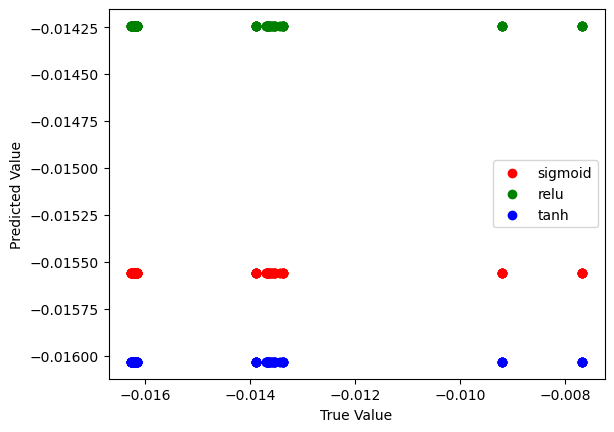

In [9]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.scatter(selflabellist,preds2, c='green',label='relu')
plt.scatter(selflabellist,preds3, c='blue', label='tanh')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.savefig('de7layercomp500epoch.png')
plt.show()

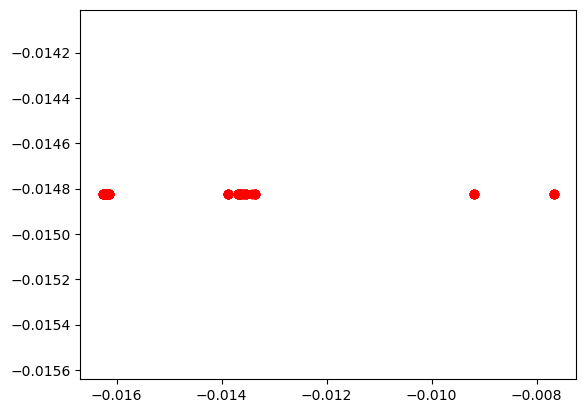

In [12]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.show()

In [13]:
model1=keras.Sequential([
    keras.layers.Input(shape=(64,)),
    keras.layers.Dense(200,activation='softmax')
    ])
model2=model1
model3=model1
for i in range(2):
    model1.add(keras.layers.Dense(200,activation='sigmoid'))
    model2.add(keras.layers.Dense(200,activation='relu'))
    model3.add(keras.layers.Dense(200,activation='tanh'))

model1.add(keras.layers.Dense(1))
model2.add(keras.layers.Dense(1))
model3.add(keras.layers.Dense(1))

model1.compile('Adam',loss='huber')
model1.fit(selfdataset,epochs=50)
preds1=model1.predict(selfdataset)

model2.compile('Adam',loss='huber')
model2.fit(selfdataset,epochs=50)
preds2=model2.predict(selfdataset)

model3.compile('Adam',loss='huber')
model3.fit(selfdataset,epochs=50)
preds3=model3.predict(selfdataset)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0099 
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 4.0143e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6772e-06  
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3122e-06 
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1376e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4011e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8551e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5284e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 5.7567e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4734e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7051e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4742e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4105e-05 
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1477e

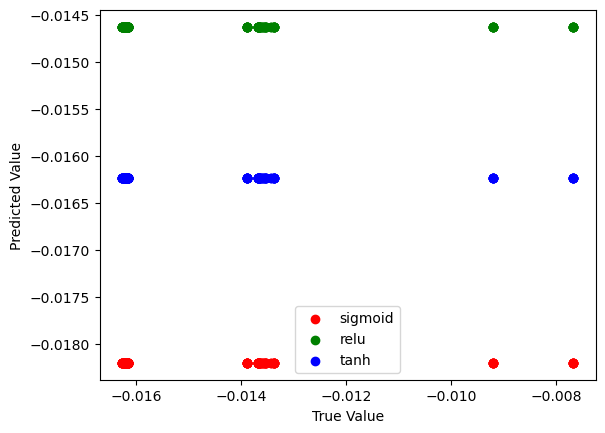

In [14]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.scatter(selflabellist,preds2, c='green',label='relu')
plt.scatter(selflabellist,preds3, c='blue', label='tanh')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.savefig('d22layercomp.png')
plt.show()

In [15]:
model1=keras.Sequential([
    keras.layers.Input(shape=(64,)),
    keras.layers.Dense(200,activation='softmax')
    ])
model2=model1
model3=model1

model1.add(keras.layers.Dense(200,activation='sigmoid'))
model2.add(keras.layers.Dense(200,activation='relu'))
model3.add(keras.layers.Dense(200,activation='tanh'))

model1.add(keras.layers.Dense(1))
model2.add(keras.layers.Dense(1))
model3.add(keras.layers.Dense(1))

model1.compile('Adam',loss='huber')
model1.fit(selfdataset,epochs=50)
preds1=model1.predict(selfdataset)

model2.compile('Adam',loss='huber')
model2.fit(selfdataset,epochs=50)
preds2=model2.predict(selfdataset)

model3.compile('Adam',loss='huber')
model3.fit(selfdataset,epochs=50)
preds3=model3.predict(selfdataset)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1068
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 6.7983e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 1.0615e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 8.1766e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1.6233e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1977e-05 
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 1.2403e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3027e-05 
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4486e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.7588e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 1.7881e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0943e-05  
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0720e-05  
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

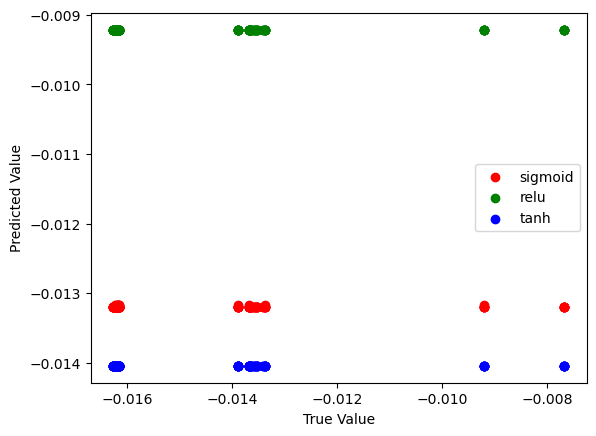

In [16]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.scatter(selflabellist,preds2, c='green',label='relu')
plt.scatter(selflabellist,preds3, c='blue', label='tanh')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.savefig('d21layercomp.png')
plt.show()

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 1.4443e-07
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 4.3779e-07
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 1.1874e-07
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 1.0740e-07
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 1.3284e-07
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 1.6950e-07
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 1.4423e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 1.1125e-07
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 4.6059e-07
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 1.2421e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 8.2857e-08
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 7.8555e-08
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 1.4855e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 569

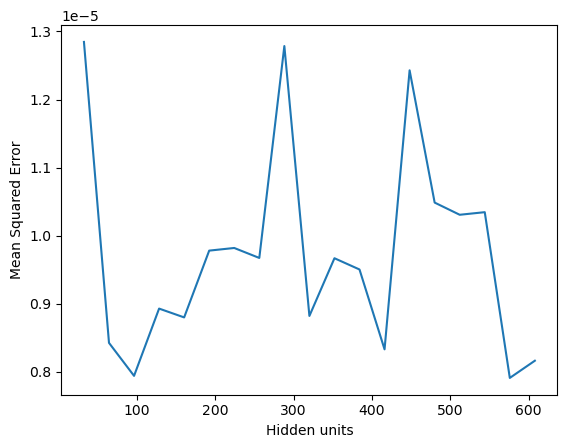

In [9]:
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import mean_squared_error

units_list=[i for i in range(32,640,32)]
def buildmodel(units):
    model=keras.Sequential([
        keras.layers.Input(shape=(64,)),
        keras.layers.Dense(units,activation='softmax'),
        keras.layers.Dense(1)
    ])
    model.compile('Adam',loss='huber')
    return model

mselist=[]
for units in units_list:
    keras.backend.clear_session()
    gc.collect
    buildmodel(units)
    model.fit(selfdataset,epochs=50)
    predictions=model.predict(selfdataset)
    mselist.append(mean_squared_error(selflabellist,predictions))

plt.plot(units_list,mselist)
plt.xlabel('Hidden units')
plt.ylabel('Mean Squared Error')
plt.savefig('UnitsvMSE.png')
plt.show()

In [17]:
model=keras.Sequential([
        keras.layers.Input(shape=inp_shape),
        keras.layers.Dense(640,activation='softmax'),
        keras.layers.Dense(1)
    ])
model.compile('Adam',loss='huber')
model.fit(selfdataset,epochs=250)
predictions=model.predict(selfdataset)

Epoch 1/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - loss: 7.3667e-06
Epoch 2/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 8.8482e-07
Epoch 3/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 8.4182e-07
Epoch 4/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 5.3648e-07
Epoch 5/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 4.7199e-07
Epoch 6/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 3.7473e-07
Epoch 7/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 5.7610e-07
Epoch 8/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 3.6825e-07
Epoch 9/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - loss: 4.0108e-07
Epoch 10/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 3.6335e-07
Epoch 11/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 4.3814e-07
Epoch 12/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 4.0471e-07
Epoch 13/250
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 5.4126e-07
Epoch 14/250
166/166 ━━━━━━━━━━━━━

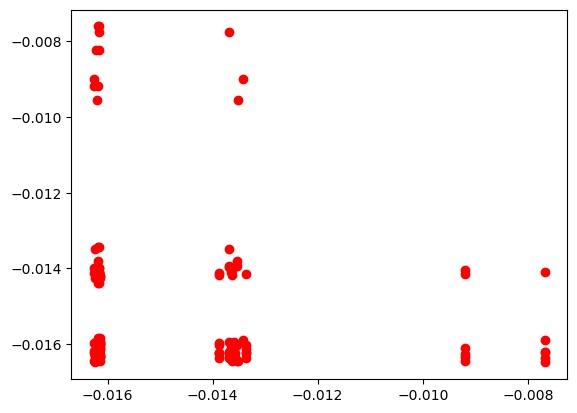

In [18]:
plt.scatter(selflabellist,predictions, c='red')
plt.show()

In [156]:
import tensorflow as tf

trainselffeats=np.stack(selffeaturelist[:120])
trainselfaddfeats=np.stack(selfaddfeatslist[:120])
trainselflabels=np.stack(selflabellist[:120])
testfeats=np.stack(selffeaturelist[120:])
testaddfeats=np.stack(selfaddfeatslist[120:])
testselflabels=np.stack(selflabellist[120:])



# Define NN1
class NN1(tf.keras.Model):
    def __init__(self):
        super(NN1, self).__init__()
        self.dense1 = tf.keras.layers.Dense(640, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(3)
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Define NN2
class NN2(tf.keras.Model):
    def __init__(self):
        super(NN2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Instantiate the models
nn1 = NN1()
nn2 = NN2()

# Optimizers
optimizer = tf.keras.optimizers.Adam()

# Loss function
loss_fn = tf.keras.losses.Huber()

# Training loop
epochs = 2500
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Forward pass through NN1
        nn1_output = nn1(trainselffeats)
        
        # Combine NN1 output with additional features for NN2 input
        nn2_input = tf.concat([nn1_output, trainselfaddfeats], axis=1)
        
        # Forward pass through NN2
        y_pred = nn2(nn2_input)
        
        # Calculate loss
        loss = loss_fn(trainselflabels, y_pred)
    
    # Compute gradients and apply updates
    gradients = tape.gradient(loss, nn1.trainable_variables + nn2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn1.trainable_variables + nn2.trainable_variables))
    
    # Print loss
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')



Epoch 1, Loss: 0.010130730457603931
Epoch 2, Loss: 0.004443000070750713
Epoch 3, Loss: 0.0012088441289961338
Epoch 4, Loss: 0.0001835643342928961
Epoch 5, Loss: 0.0007125540287233889
Epoch 6, Loss: 0.0018035855609923601
Epoch 7, Loss: 0.0025710021145641804
Epoch 8, Loss: 0.0026628696359694004
Epoch 9, Loss: 0.0021964670158922672
Epoch 10, Loss: 0.0014661133754998446
Epoch 11, Loss: 0.000762430892791599
Epoch 12, Loss: 0.0002891008625738323
Epoch 13, Loss: 0.00013254658551886678
Epoch 14, Loss: 0.0002590531075838953
Epoch 15, Loss: 0.0005423364927992225
Epoch 16, Loss: 0.0008230707026086748
Epoch 17, Loss: 0.0009765526629053056
Epoch 18, Loss: 0.0009530286188237369
Epoch 19, Loss: 0.0007788549992255867
Epoch 20, Loss: 0.0005294289439916611
Epoch 21, Loss: 0.0002931123599410057
Epoch 22, Loss: 0.0001390779943903908
Epoch 23, Loss: 9.847934416029602e-05
Epoch 24, Loss: 0.00015942809113766998
Epoch 25, Loss: 0.0002712236891966313
Epoch 26, Loss: 0.00037200708175078034
Epoch 27, Loss: 0.000

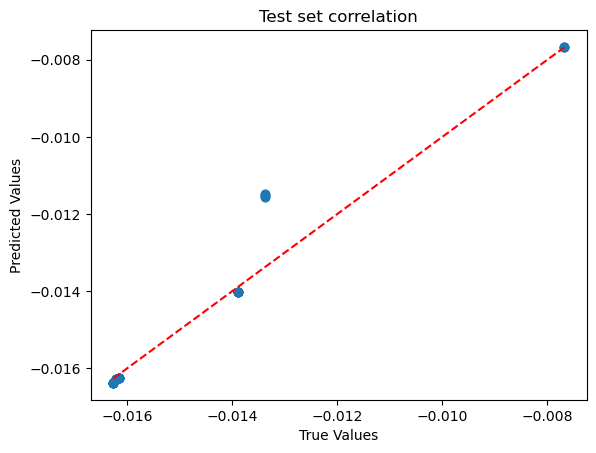

In [173]:
def predict(x1, x2):
    # Forward pass through NN1
    nn1_output = nn1(x1)
    
    # Combine NN1 output with additional features for NN2 input
    nn2_input = tf.concat([nn1_output, x2], axis=1)
    
    # Forward pass through NN2 to get the final prediction
    y_pred = nn2(nn2_input)
    
    return y_pred
nn1.save('alkaneselfnn1_model.keras')
nn2.save('alkaneselfnn2_model.keras')
predictions=predict(testfeats,testaddfeats)

plt.scatter(testselflabels,predictions)
plt.plot((min(testselflabels),max(testselflabels)),(min(testselflabels),max(testselflabels)),c='red',linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test set correlation')
plt.savefig('testselfset.png')
plt.show()

In [158]:
print(predictions)

tf.Tensor(
[[-0.00766837]
 [-0.00766837]
 [-0.00768029]
 [-0.00768029]
 [-0.01637796]
 [-0.01637796]
 [-0.01627633]
 [-0.01627633]
 [-0.01401548]
 [-0.01401548]
 [-0.01401998]
 [-0.01401998]
 [-0.01637919]
 [-0.01637919]
 [-0.0162762 ]
 [-0.0162762 ]
 [-0.01627615]
 [-0.01627615]
 [-0.01637816]
 [-0.01637816]
 [-0.01401422]
 [-0.01401422]
 [-0.01401796]
 [-0.01401796]
 [-0.01627692]
 [-0.01627692]
 [-0.01637922]
 [-0.01637922]
 [-0.01626126]
 [-0.01626126]
 [-0.01626079]
 [-0.01626079]
 [-0.01149572]
 [-0.01149572]
 [-0.01626137]
 [-0.01626137]
 [-0.01626082]
 [-0.01626082]
 [-0.01154883]
 [-0.01154883]
 [-0.01149337]
 [-0.01149337]
 [-0.01626045]
 [-0.01626045]
 [-0.01626102]
 [-0.01626102]], shape=(46, 1), dtype=float32)


In [231]:
trainnoselffeatures=np.stack(noselffeatlist[:1500])
trainnoselfaddfeatures=np.stack(noselfaddfeatlist[:1500])
trainnoselflabels=np.stack(noselflabellist[:1500])

testnoselffeatures=np.stack(noselffeatlist[1500:])
testnoselfaddfeatures=np.stack(noselfaddfeatlist[1500:])
testnoselflabels=np.stack(noselflabellist[1500:])

# Define NN1
class NN1(tf.keras.Model):
    def __init__(self):
        super(NN1, self).__init__()
        self.flatten = tf.keras.layers.Flatten()  # Flatten layer
        self.dense1 = tf.keras.layers.Dense(4224, activation='softmax')
        self.dense2 = tf.keras.layers.Dense(3)
    
    def call(self, inputs):
        x = self.flatten(inputs)  # Flatten 66x64 to 4224
        x = self.dense1(x)
        return self.dense2(x)

# Define NN2
class NN2(tf.keras.Model):
    def __init__(self):
        super(NN2, self).__init__()
        self.dense1 = tf.keras.layers.Dense(100, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1) 
    
    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

# Instantiate the models
nn1 = NN1()
nn2 = NN2()

# Optimizers
optimizer = tf.keras.optimizers.Adam()

# Loss function
loss_fn = tf.keras.losses.Huber()

# Training loop
epochs = 2500
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Forward pass through NN1
        nn1_output = nn1(trainnoselffeatures)
        
        # Combine NN1 output with additional features for NN2 input
        nn2_input = tf.concat([nn1_output, trainnoselfaddfeatures], axis=1)
        
        # Forward pass through NN2
        y_pred = nn2(nn2_input)
        
        # Calculate loss
        loss = loss_fn(trainnoselflabels, y_pred)
    
    # Compute gradients and apply updates
    gradients = tape.gradient(loss, nn1.trainable_variables + nn2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, nn1.trainable_variables + nn2.trainable_variables))
    
    # Print loss
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')



Epoch 1, Loss: 0.06345044821500778
Epoch 2, Loss: 0.038720160722732544
Epoch 3, Loss: 0.02111898921430111
Epoch 4, Loss: 0.01032986305654049
Epoch 5, Loss: 0.005093705374747515
Epoch 6, Loss: 0.004326051566749811
Epoch 7, Loss: 0.00629347562789917
Epoch 8, Loss: 0.008948897011578083
Epoch 9, Loss: 0.010705245658755302
Epoch 10, Loss: 0.01090269349515438
Epoch 11, Loss: 0.009663828648626804
Epoch 12, Loss: 0.007528787478804588
Epoch 13, Loss: 0.005080928094685078
Epoch 14, Loss: 0.0028652579057961702
Epoch 15, Loss: 0.0012641388457268476
Epoch 16, Loss: 0.00045054586371406913
Epoch 17, Loss: 0.0004153182089794427
Epoch 18, Loss: 0.0009516194695606828
Epoch 19, Loss: 0.0017456861678510904
Epoch 20, Loss: 0.00249088485725224
Epoch 21, Loss: 0.0029647827614098787
Epoch 22, Loss: 0.00306282308883965
Epoch 23, Loss: 0.0027922200970351696
Epoch 24, Loss: 0.0022578448988497257
Epoch 25, Loss: 0.0016093708109110594
Epoch 26, Loss: 0.0009985456708818674
Epoch 27, Loss: 0.000541128043550998
Epoch

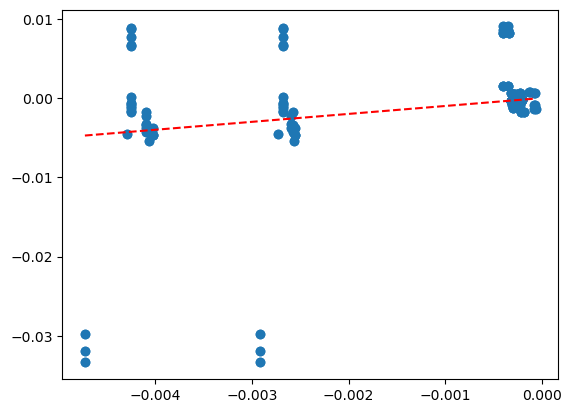

In [233]:
def predict(x1, x2):
    # Forward pass through NN1
    nn1_output = nn1(x1)
    
    # Combine NN1 output with additional features for NN2 input
    nn2_input = tf.concat([nn1_output, x2], axis=1)
    
    # Forward pass through NN2 to get the final prediction
    y_pred = nn2(nn2_input)
    
    return y_pred

predictions=predict(testnoselffeatures,testnoselfaddfeatures)

plt.scatter(testnoselflabels,predictions)
plt.plot((min(testnoselflabels),max(testnoselflabels)),(min(testnoselflabels),max(testnoselflabels)),c='red',linestyle='--')
plt.savefig('test.png')